# Import

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import gc
import time
import random
import sys
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A
from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output, display
from ipywidgets import IntSlider, Output

import copy
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor

from tqdm import tqdm
tqdm.pandas()

# Config

In [2]:
running_locally = False

In [3]:
if running_locally:
    competition_data_dir = '../data/hubmap-organ-segmentation'
    data_dir = '../data'
else:
    competition_data_dir = '/kaggle/input/hubmap-organ-segmentation'
    data_dir = '/kaggle/working'

In [4]:
class CFG:

    # Flags
    running_locally = running_locally
    running_on_test = None

    debugging = False
    display_images = True
    test_augmentations = True
    
    use_test_ds = False

    # Device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # interpolation = cv2.INTER_LINEAR # resnet interpolation is bilinear
    interpolation = cv2.INTER_CUBIC # efficentnet interpolation is cubic

    # Folds
    folds_num = 10
    folds_seed=1
    folds_to_train_on = [1,2]
    test_fold = 9


    val_size = 32
    train_size = 310

    random_state = 101
    fix_seed = 2023

    # Training params

    train_base_model_also = False
    continue_training_with_small_lr = False

    debug_bs = 2
    train_bs = 4
    val_bs = 4
    sumb_bs = 4
    output_channels = 2

    optimizer_learning_rate = 1e-3
    optimizer_weight_decay = 0
    gradient_accumulations = 4*2
    
    train_epochs = 20
    debug_epochs = 2

    # Model params

    # base_model_output_shape = [1280, 4, 4] # for img_size 128
    base_model_output_shape = [1280, 7, 7] # for img_size 224
    base_model_output_channels = base_model_output_shape[0]

    # Input Image params
    input_channels = 3
    # bmodel_image_size = 300
    bmodel_image_size = 320
    
    loaded_image_size = 512
    loaded_image_size = 448
    
    bmodel_image_shape = (bmodel_image_size, bmodel_image_size)

    # Weights
    
    efficentnet_b3_weights_path = '../input/efficentnet-b3-weights/efficientnet_b3_weights.bin'

    best_model_path = f'{data_dir}/best_epoch.bin'
    last_epoch_weights_path = f'{data_dir}/last_epoch.bin'
    first_run_save = f'{data_dir}/unet_efficentntet_first_run_1.bin'
    best_fold_path = f'{data_dir}/best_epoch_fold.bin'

    to_load_prev_weights = '/kaggle/input/hubmap-unet-resnet-train-best-epoch/best_epoch.bin'
    
    # Remove lung organ because it's results are lot worse
    remove_lung = True

In [5]:
assert CFG.test_fold not in CFG.folds_to_train_on, 'Test fold should not be among folds used for validation'

In [6]:
def fix_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
fix_seed(CFG.fix_seed)

In [8]:
print('Recursion limit prev', sys.getrecursionlimit())
sys.setrecursionlimit(10**5)
print('Recursion limit new', sys.getrecursionlimit())

Recursion limit prev 3000
Recursion limit new 100000


# Paths

### Set File Paths

In [9]:
train_images_dir = f'{competition_data_dir}/train_images'
test_images_dir = f'{competition_data_dir}/test_images'
train_annotations_dir = f'{competition_data_dir}/train_annotations'

train_csv_path = f'{competition_data_dir}/train.csv'
test_csv_path = f'{competition_data_dir}/test.csv'
sample_subm_csv_path = f'{competition_data_dir}/sample_submission.csv'

train_processed_path = f'{data_dir}/train_df.pkl'
test_processed_path = f'{data_dir}/test_df.pkl'

In [10]:
def load_train_df():
    return pd.read_pickle(train_processed_path)

def load_test_df():
    return pd.read_pickle(test_processed_path)

### Set running env

In [11]:
sample_subm_df = pd.read_csv(sample_subm_csv_path)
if len(sample_subm_df) > 1:
    CFG.running_on_test_set = True
else:
    CFG.running_on_test_set = False
del sample_subm_df

In [12]:
def create_mock_sample_subm():
    df = load_train_df()
    x = df.sample(20)[['id', 'rle']].copy()
    x['rle'] = ''
    return x
    
def load_sample_subm_df(create_mock=False):
    assert CFG.running_on_test_set is not None

    if CFG.running_on_test_set:
        sample_subm_df = pd.read_csv(sample_subm_csv_path)
    else:
        if create_mock:
            sample_subm_df = create_mock_sample_subm()
        else:
            sample_subm_df = pd.read_csv(sample_subm_csv_path)
        
    return sample_subm_df

# Drawing Functions

In [13]:
def plot_multiple_images(imgs, rows_num=3, cols_num=4, img_size=4, no_axis_info=False, titles=[]):
    num_imgs_to_plot = min(len(imgs), rows_num*cols_num)
    rows_num = round(num_imgs_to_plot / cols_num + 0.5)
    plt.figure(figsize=(img_size * cols_num + 2, img_size * rows_num + 2))
    for i in range(num_imgs_to_plot):

        plt.subplot(rows_num, cols_num, i+1)
        plt.imshow(imgs[i])

        if len(titles) > 0:
            plt.title(titles[i])

        if no_axis_info: 
            plt.axis('off') # remove axis info

    plt.tight_layout()
    plt.show()
def load_img(path):
    return cv2.imread(path, flags=cv2.IMREAD_UNCHANGED)
def generate_mask(mask_shape, segmentation_column, drawing_value=100, save_as_int=True):
    if save_as_int:
        mask_type = np.uint8
    else:
        mask_type = np.float32
        drawing_value = 1.0
        
    if len(segmentation_column) == 0:
        return np.zeros(mask_shape, dtype=mask_type)
    else:
        h = mask_shape[0]
        w = mask_shape[1]
        mask_img = np.zeros(h*w, dtype=mask_type)
        segmentation_info = segmentation_column.split(' ')
        if len(segmentation_info) % 2 != 0:
            raise Exception('Segmentation\'s length is not divisible by 2.')
        for i in range(len(segmentation_info) // 2):
            segm_position = int(segmentation_info[i*2])
            segm_len = int(segmentation_info[i*2+1])

            for j in range(segm_len):
                mask_img[segm_position+j] = drawing_value

        return mask_img.reshape((h,w)).T
# def add_red_mask(on_img, mask_img):
#     assert len(on_img.shape) == 3

#     on_img = on_img.astype(np.int16)
#     on_img[:,:,0] = np.clip(on_img[:,:,0] + mask_img, 0, 255)

#     return on_img.astype(np.uint8)
# def draw_msk_over_img(img, msk):
#     assert img.shape[2] == 3
#     assert len(msk.shape) == 2

#     img_to_show = add_red_mask(img, msk)
#     return img_to_show

# Load Dataframe

In [14]:
whole_train_df = pd.read_pickle(f'/kaggle/input/hubmap-data-prep-ds/train_df.pkl')
print(whole_train_df.shape)

(351, 15)


In [15]:
if CFG.remove_lung:
    whole_train_df = whole_train_df.loc[whole_train_df.organ != 'lung'].reset_index(drop=True)
    print(whole_train_df.shape)

(303, 15)


In [16]:
whole_train_df.organ.value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
Name: organ, dtype: int64

In [17]:
whole_train_df['resized_img_path'] = whole_train_df['resized_img_path'].apply(
    lambda p: p.replace("/kaggle/working/", "/kaggle/input/hubmap-data-prep-ds/"))

whole_train_df['resized_mask_path'] = whole_train_df['resized_mask_path'].apply(
    lambda p: p.replace("/kaggle/working/", "/kaggle/input/hubmap-data-prep-ds/"))

whole_train_df['mask_path'] = whole_train_df['mask_path'].apply(
    lambda p: p.replace("/kaggle/working/", "/kaggle/input/hubmap-data-prep-ds/"))

In [18]:
print(whole_train_df.shape)

(303, 15)


In [19]:
whole_train_df.head(2)

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   

    sex                                           img_path  \
0  Male  /kaggle/input/hubmap-organ-segmentation/train_...   
1  Male  /kaggle/input/hubmap-organ-segmentation/train_...   

                                           ann_paths  \
0  /kaggle/input/hubmap-organ-segmentation/train_...   
1  /kaggle/input/hubmap-organ-segmentation/train_...   

                                           mask_path  \
0  /kaggle/input/hubmap-data-prep-ds/masks/10044.npy   
1  /kaggle/input/hubmap-data-prep-ds/masks/10274.npy   

                                   resized_mask_path  \
0  /kaggle/input/hubmap-data-prep-ds/resized_mask...   
1  /kaggle/input/hubmap-data-prep-ds/resized_mask...   

                                    resized_img_path  
0  /kaggle/input/hubmap-data-prep-ds/resized_imag...  
1  /kaggle/input/hubmap-data-prep-ds/resized_imag...

## Folds

In [20]:
skf = StratifiedKFold(CFG.folds_num, shuffle=True, random_state=CFG.random_state)
whole_train_df['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(whole_train_df, whole_train_df['organ'])):
    whole_train_df.loc[valid_idx, 'fold'] = i

In [21]:
if CFG.debugging:
    print('Amount of examples for each organ per fold:')
    print(whole_train_df.groupby(['fold']).id.size())
#     print(whole_train_df.groupby(['fold','organ'])['id'].count())

## Split to train and val

In [22]:
val_df = whole_train_df.loc[whole_train_df.fold == CFG.folds_to_train_on[0]].copy()
print(val_df.shape)
print(val_df.organ.value_counts())

(31, 16)
kidney            10
prostate          10
largeintestine     6
spleen             5
Name: organ, dtype: int64


In [23]:
if CFG.use_test_ds is not False:
    test_df = whole_train_df.loc[whole_train_df.fold == CFG.test_fold].copy()
    print(test_df.shape)
    print(test_df.organ.value_counts())

In [24]:
def sample_val_to_size(val_df, val_size=CFG.val_size, keep_more_numerous=True):
    val_df['weights'] = 1.0
    organ_value_counts = val_df.organ.value_counts()

    if keep_more_numerous is not None:
        if keep_more_numerous:
            # keep those organs that are less numerous - spleen, lung
            val_df.weights = val_df.organ.apply(lambda x: int(organ_value_counts[x]))
        else:
            # keep those organs that are more numerous - prostate, kidney
            val_df.weights = val_df.organ.apply(lambda x: 1 / float(organ_value_counts[x]))


    if len(val_df) >= val_size:
        val_df = val_df.sample(val_size, axis=0, weights='weights', random_state=CFG.random_state)
    else:
        val_df = val_df.sample(val_size, axis=0, weights='weights', replace=True, random_state=CFG.random_state)
    del val_df['weights']

    return val_df

In [25]:
val_df = sample_val_to_size(val_df)
print(val_df.shape)
print(val_df.organ.value_counts())

(32, 16)
prostate          18
kidney            13
largeintestine     1
Name: organ, dtype: int64


In [26]:
if CFG.use_test_ds is not False:
    test_df = sample_val_to_size(test_df, val_size=CFG.val_size, keep_more_numerous=True)
    print(test_df.shape)
    print(test_df.organ.value_counts())

In [27]:
if CFG.use_test_ds is not False:
    remove_indexes = list(val_df.index) + list(test_df.index)
else:
    remove_indexes = list(val_df.index)

train_df = whole_train_df.drop(remove_indexes[1:]).copy() # [1:] - to have size of 320 instead of 319

In [28]:
train_df = train_df.sample(len(train_df), random_state=CFG.random_state)
train_df.reset_index(inplace=True, drop=True)
val_df = val_df.sample(len(val_df), random_state=CFG.random_state)
val_df.reset_index(inplace=True, drop=True)

if CFG.use_test_ds is not False:
    test_df = test_df.sample(len(test_df), random_state=CFG.random_state)
    test_df.reset_index(inplace=True, drop=True)
else:
    test_df = val_df.copy()

In [29]:
print('Train:')
print(train_df.shape)
print(train_df.organ.value_counts())

Train:
(285, 16)
kidney            91
prostate          84
largeintestine    57
spleen            53
Name: organ, dtype: int64


In [30]:
print('Val:')
print(val_df.shape)
print(val_df.organ.value_counts())

Val:
(32, 16)
prostate          18
kidney            13
largeintestine     1
Name: organ, dtype: int64


In [31]:
if CFG.use_test_ds is False:
    print('Test df is set to be same as val df')

print('Test:')
print(test_df.shape)
print(test_df.organ.value_counts())

Test df is set to be same as val df
Test:
(32, 16)
prostate          18
kidney            13
largeintestine     1
Name: organ, dtype: int64


# Create Dataset

In [32]:
def load_img_for_ds(path):
    # img = np.load(path)
    img = load_img(path)
    img = img.astype('float32') 
    img /= 255.0 # scale image to [0, 1]
    return img

def load_res_img_for_ds(path):
    img = np.load(path)
    img = img.astype('float32') 
    img /= 255.0 # scale image to [0, 1]

    return img

def load_msk_for_ds(path):
    msk = np.load(path)
    msk = msk[..., np.newaxis]
    # msk = msk.astype('float32') # perhaps not needed to cast
    # msk -= 1 # 
    # msk/=255.0
    
    return msk

def resize_img(image, new_shape=CFG.bmodel_image_shape):
    return cv2.resize(image, new_shape, interpolation=CFG.interpolation) # this kind of resizing streches image

In [33]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['resized_img_path'].tolist()
        self.msk_paths  = df['resized_mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = load_res_img_for_ds(img_path)

        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk_for_ds(msk_path)

            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
                
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))

            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
                
            img = np.transpose(img, (2, 0, 1))
            
            return torch.tensor(img)


# Augmentations

In [34]:
data_transforms = {
    "train": A.Compose([

        A.OneOf([
            A.CenterCrop(height=int(CFG.loaded_image_size * 0.9), width=int(CFG.loaded_image_size * 0.9), p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=45, interpolation=CFG.interpolation, p=1),
        ], p=0.5),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5), 

        A.RandomRotate90(p=0.5),

        A.ChannelShuffle(p=0.5),

        A.SomeOf([
            A.ChannelShuffle(),
            A.HueSaturationValue(hue_shift_limit=140, sat_shift_limit=0.4, val_shift_limit=0),
            A.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.5),
            A.GaussNoise(var_limit=0.05, mean=0.0),
            A.GaussianBlur(blur_limit=(3,7), p=0.5),
        ], n=2, p=0.5),

        A.Resize(*CFG.bmodel_image_shape, interpolation=CFG.interpolation),
        # A.Resize(*CFG.bmodel_image_shape, interpolation=CFG.interpolation),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.bmodel_image_shape, interpolation=CFG.interpolation),
        # A.Resize(*CFG.bmodel_image_shape, interpolation=CFG.interpolation),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ], p=1.0)
}

In [35]:
# CFG.test_augmentations = False

In [36]:
if CFG.test_augmentations:
    i = np.random.randint(len(train_df))
    img_path = train_df.iloc[i].resized_img_path
    print(img_path)
    image = load_res_img_for_ds(img_path)
    print(image.shape)
    # image = resize_img(image, new_shape=CFG.bmodel_image_shape)
    # print(image.shape)

/kaggle/input/hubmap-data-prep-ds/resized_images/16659.npy
(1024, 1024, 3)


(320, 320, 3)


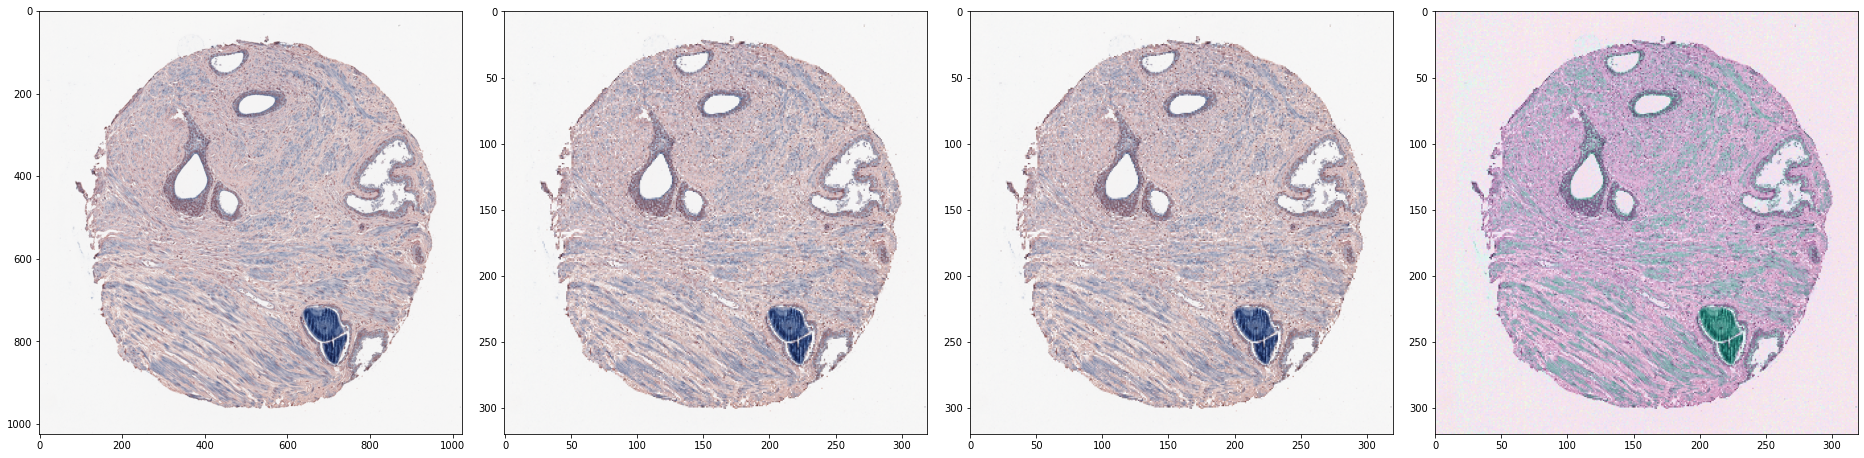

In [37]:
if CFG.test_augmentations:
    transform = A.Compose([
        # A.GaussianBlur(blur_limit=(3,7), p=1),
        A.HueSaturationValue(hue_shift_limit=120, sat_shift_limit=0.2, val_shift_limit=0),
        A.Resize(*CFG.bmodel_image_shape, interpolation=CFG.interpolation),

    ])
    transformed_image_1 = transform(image=image)['image']
    transformed_image_2 = transform(image=image)['image']
    transformed_image_3 = transform(image=image)['image']

    print(transformed_image_1.shape)

    imgs_to_plot = [image, transformed_image_1,transformed_image_2,transformed_image_3]

    plot_multiple_images(imgs_to_plot, img_size=6, rows_num=2)

In [38]:
IMAGE_RGB_MEAN = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
IMAGE_RGB_STD  = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

def denormalize_img(img):
    img = img*IMAGE_RGB_STD+IMAGE_RGB_MEAN
    img = img / img.max()
    return img

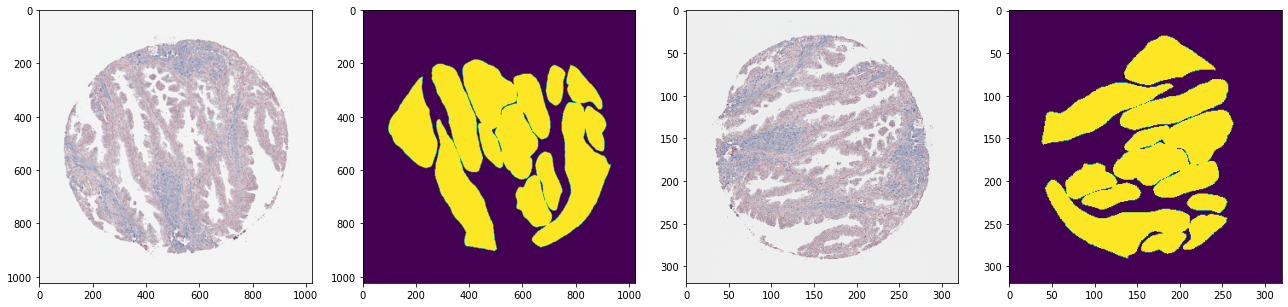

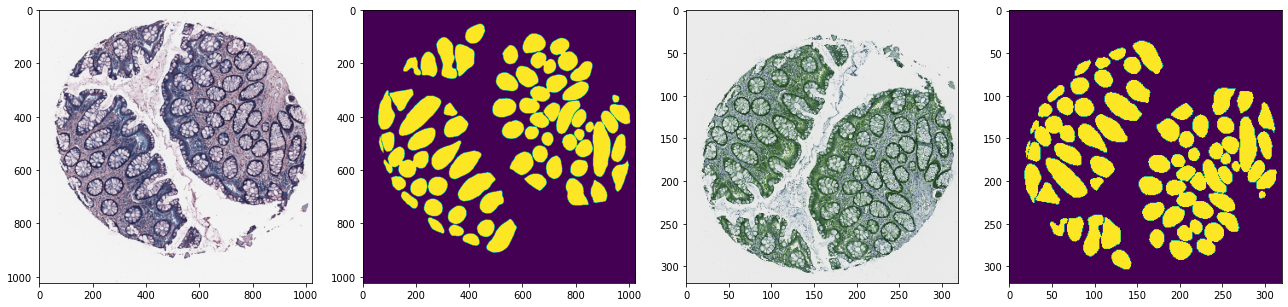

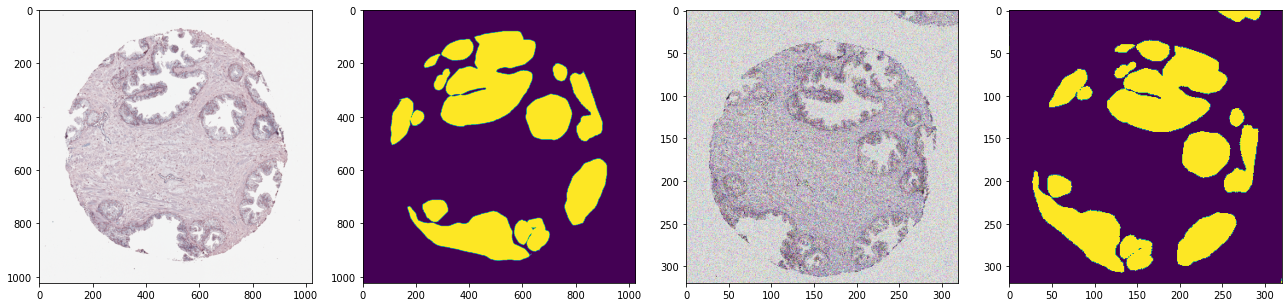

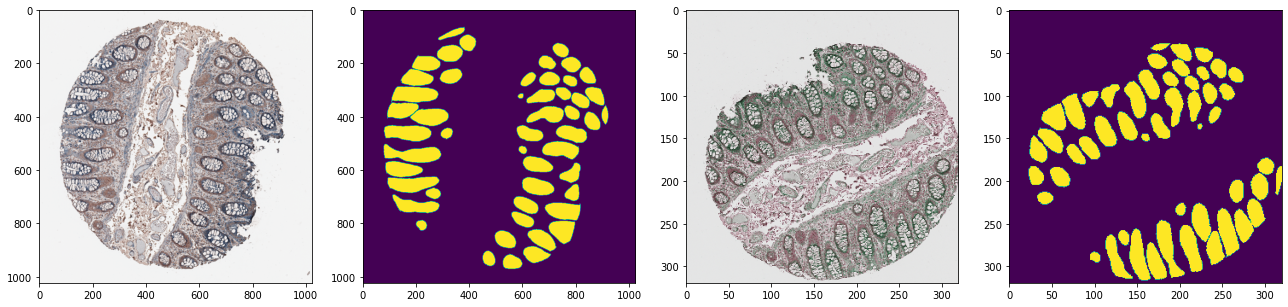

In [39]:
if CFG.test_augmentations:
    df = train_df.sample(CFG.debug_bs*2)

    ds = BuildDataset(df, transforms=None)

    i = 0
    imgs_to_plot = [[] for _ in range(len(ds))]

    for i,(img, msk) in enumerate(ds):
        imgs_to_plot[i].append(img.permute([1,2,0]))
        imgs_to_plot[i].append(msk.permute([1,2,0]))
        
    ds = BuildDataset(df, transforms=data_transforms['train'])

    for i,(img, msk) in enumerate(ds):
        img = img.permute([1,2,0]).numpy()
        den_img = denormalize_img(img)
        imgs_to_plot[i].append(den_img)
        imgs_to_plot[i].append(msk.permute([1,2,0]))

    for i in range(len(ds)):
        plot_multiple_images(imgs_to_plot[i])

# Data Loader

In [40]:
def prepare_train_loader(df, batch_size=CFG.train_bs):
    df = df.reset_index(drop=True)
    train_dataset = BuildDataset(df, transforms=data_transforms['train'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True, drop_last=False)
    
    return train_loader

def prepare_valid_loader(df, batch_size=CFG.val_bs):
    df = df.reset_index(drop=True)
    valid_dataset = BuildDataset(df, transforms=data_transforms['valid'])
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)
    
    return valid_loader

def prepare_test_loader(df, batch_size=CFG.val_bs, transforms=data_transforms['valid']):
    df = df.reset_index(drop=True)
    dataset = BuildDataset(df, transforms=transforms)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=True)
    
    return loader

# Visualize Loader images

In [41]:
# Plot images, masks and predictions in 3 rows
# Function is not well written, but works
def plot_batch(imgs, msks, pred_msks=None, size=4, figure_height=4, figure_width=4):
    imgs = imgs.cpu()
    msks = msks.cpu()
    
    if size==1:
        plt.figure(figsize=(3 * figure_width, figure_height))

        plt.subplot(1, 4, 1)
        img = imgs[0,].numpy()*255.0
        img = img.astype('uint8')
        img = np.transpose(img, (1, 2, 0)) 
        plt.imshow(img)

        plt.subplot(1, 4, 2)
        msk = msks[0].numpy()
        msk = np.transpose(msk, (1, 2, 0)) 
        plt.imshow(msk)

        if pred_msks is not None:
            plt.subplot(1, 4, 3)
            plt.imshow(np.array(pred_msks[0]))

        plt.tight_layout()
        plt.show()

    else:
        # Plot images
        plt.figure(figsize=(size * figure_width, figure_height))
        for idx in range(size):
            plt.subplot(1, size, idx+1)
            img = imgs[idx,].numpy()*255.0
            img = img.astype('uint8')
            img = np.transpose(img, (1, 2, 0)) 
            plt.imshow(img)
        plt.tight_layout()
        plt.show()

        # Plot masks
        plt.figure(figsize=(size * figure_width, figure_height))
        for idx in range(size):
            plt.subplot(1, size, idx+1)
            msk = msks[idx,].numpy()
            msk = np.transpose(msk, (1, 2, 0)) 
            plt.imshow(msk)
        plt.tight_layout()
        plt.show()

        # Plot masks predictions
        if pred_msks is not None:
            plt.figure(figsize=(size * figure_width, figure_height))
            for idx in range(size):
                plt.subplot(1, size, idx+1)
                pred_msk = np.array(pred_msks[idx])
                # msk = np.transpose(msk, (1, 2, 0)) 
                plt.imshow(pred_msk)
            plt.tight_layout()
            plt.show()

In [42]:
def add_red_mask(on_img, mask_img):
    assert len(on_img.shape) == 3

    # on_img = on_img.astype(np.int16)
    on_img[:,:,0] = np.clip(on_img[:,:,0] + mask_img[:,:,0], 0, 1.0)

    return on_img.astype(np.float32)
def draw_msk_over_img(img, msk):
    assert img.shape[2] == 3
    assert len(msk.shape) == 3

    img_to_show = add_red_mask(img, msk)
    return img_to_show

# Create Model

In [43]:
def double_conv(in_channels, out_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True)
    )
    
def upstack_module(in_channels, out_channels, kernel_size):
    return torch.nn.Sequential(
        torch.nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=kernel_size, stride=2, padding=1, output_padding=1,
            bias=False),
        torch.nn.BatchNorm2d(out_channels, momentum=0.1), # (1 - tf momentum)
        torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        # torch.nn.ReLU6(),
    )

In [44]:
class Unet(torch.nn.Module):
    def __init__(self, base_model):
        super(Unet, self).__init__()

        # base_model

        return_nodes = {
            '1.1.add': 'layer1', # 24
            '2.2.add': 'layer2', # 32
            '3.2.add': 'layer3', # 48
            '5.4.add': 'layer4', # 136
            '8': 'layer5', # 1536
        }

        self.body = create_feature_extractor(base_model, return_nodes=return_nodes)

        # chosen_up_out_ch_size = [512, 256, 128, 64]
        self.upstack_module_1 = upstack_module(in_channels=1536, out_channels=512, kernel_size=3)
        self.upstack_module_2 = upstack_module(in_channels=512, out_channels=256, kernel_size=3)
        self.upstack_module_3 = upstack_module(in_channels=256, out_channels=128, kernel_size=3)
        self.upstack_module_4 = upstack_module(in_channels=128, out_channels=64, kernel_size=3)

        # [648, 304, 160, 88, 35, 32], - amount of channels when up output is concat with skip conn output
        self.double_conv1 = double_conv(648, 512)
        self.double_conv2 = double_conv(304, 256)
        self.double_conv3 = double_conv(160, 128)
        self.double_conv4 = double_conv(88, 64)

        # Upscale conv 4 output to concat input img
        self.upstack_module_5 = upstack_module(64, 32, kernel_size=3)
        # Double conv of output and inupt img
        self.double_conv_input = double_conv(35, 32)

        self.final_conv = torch.nn.Conv2d(32, CFG.output_channels, kernel_size=1)

    def forward(self, x):
        input_imgs = x

        down_stack_outputs = self.body(x)

        x = self.upstack_module_1(down_stack_outputs['layer5'])

        x = torch.cat([x, down_stack_outputs['layer4']], dim=1)
        x = self.double_conv1(x)

        x = self.upstack_module_2(x)
        x = torch.cat([x, down_stack_outputs['layer3']], dim=1)
        x = self.double_conv2(x)

        x = self.upstack_module_3(x)
        x = torch.cat([x, down_stack_outputs['layer2']], dim=1)
        x = self.double_conv3(x)

        x = self.upstack_module_4(x)
        x = torch.cat([x, down_stack_outputs['layer1']], dim=1)
        x = self.double_conv4(x)

        x = self.upstack_module_5(x)
        x = torch.cat([x, input_imgs], dim=1)
        x = self.double_conv_input(x)

        x = self.final_conv(x)
        
        return x

In [45]:
# Base Model

def load_base_model():
    model = models.efficientnet_b3(weights=None)
    model.load_state_dict(torch.load(CFG.efficentnet_b3_weights_path))
    model.eval()

    return model

def load_prepare_base_model(freeze_params=True):
    base_model = load_base_model()
    # Take only first direct child as base model
    base_model = list(base_model.children())[0]

    if freeze_params:
        for param in base_model.parameters():
            param.requires_grad = False

    return base_model

In [46]:
def create_model(base_model=None):
    if base_model is None:
        base_model = load_prepare_base_model()

    model = Unet(base_model)
    model.eval()

    return model

In [47]:
model = create_model()

In [48]:
# Img to test model on:

img = load_res_img_for_ds(train_df.iloc[0].resized_img_path)
print(img.shape)
img1 = torch.Tensor(img).permute([2,0,1])
img1 = img1.reshape(1,*img1.shape)
img1 = torch.nn.functional.interpolate(img1, (CFG.bmodel_image_size,CFG.bmodel_image_size), mode='bicubic')
print(img1.shape)

(1024, 1024, 3)
torch.Size([1, 3, 320, 320])


In [49]:
out = model(img1)
print(out.shape)

torch.Size([1, 2, 320, 320])


In [50]:
del img, img1, out

In [51]:
def num_params(torch_module, requires_grad=True):
    if requires_grad:
        return sum(p.numel() for p in torch_module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in torch_module.parameters())


# print(f'Num params in base model non frozen  {num_params(base_model):,}')
# print(f'Num params in base model all         {num_params(base_model, False):,}')

print(f'Num params in model non frozen  {num_params(model):,}')
print(f'Num params in model all         {num_params(model, False):,}')

# 31 mil in Unet with resnet
# 4 mil in Unet with mobilenet
# 77 mil in TUnet

Num params in model non frozen  15,726,754
Num params in model all         26,422,986


In [52]:
# model = model.to(CFG.device)

# Loss/Acc

In [53]:
# Expects y_true shape [bs, img_size, img_size] -- without channels
# Example: accuracy_criterion(x, model_output[:,0,:,:])
def accuracy_criterion(y_pred, y_true):
    return torch.mean(
        torch.eq(
            y_pred.argmax(dim=1), 
            y_true
        ).half()
    )

In [54]:
class DiceLoss(torch.nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-6
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False, do_one_hot=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)

        if do_one_hot:
            target = self._one_hot_encoder(target)
            
        if weight is None:
            weight = [1] * self.n_classes

        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
            
        return loss / self.n_classes

In [55]:
def _one_hot_encoder(input_tensor):
    tensor_list = []
    for i in range(2):
        temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
        tensor_list.append(temp_prob.unsqueeze(1))
    output_tensor = torch.cat(tensor_list, dim=1)
    return output_tensor.float()

In [56]:
def dice_accuracy(y_pred, y_true, thr=0.5, dim=(2,3), epsilon=0.00001):
    # print(y_pred.shape)
    # print(y_true.shape)
    
    # Change (BS, 1, 128, 128) to (BS, 2, 128, 128)
    # That is make channel for each class
    y_true = _one_hot_encoder(y_true.squeeze(1))
    y_true = y_true.to(torch.float32)

    y_pred = (y_pred>thr).to(torch.float32)

    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

In [57]:
ce_loss = torch.nn.CrossEntropyLoss()
dice_loss = DiceLoss(n_classes=2)

def criterion(y_pred, y_true):
    return dice_loss(y_pred, y_true, softmax=True)
#     return ce_loss(y_pred, y_true.long()) * 0.2 + dice_loss(y_pred, y_true, softmax=True) * 0.8
#     return ce_loss(y_pred, y_true.long())

In [58]:
# criterion(model_out, msks[:,0,:,:])

# Visualize predictions

In [59]:
def create_mask_from_output(model_output):
    # expects shape: [channel_size, height, width] - example: [3, 128, 128]
    pred_msk = model_output.detach().cpu()
    pred_msk = torch.argmax(pred_msk, dim=0).numpy()
    pred_msk = pred_msk[...,np.newaxis]
    pred_msk = pred_msk.astype('uint8')

    return pred_msk
def create_mask_from_batch_outputs(model_outputs):
    # expects shape: [batch_size, channel_size, height, width] - example: [32, 3, 128, 128]
    pred_msks = model_outputs.detach().cpu()
    pred_msks = torch.argmax(pred_msks, dim=1).numpy()
    pred_msks = pred_msks[...,np.newaxis]
    pred_msks = pred_msks.astype('uint8')

    return pred_msks

In [60]:
def plot_imgs_msks(imgs, msks, preds=None, amount=4, size=3):
    assert len(imgs.shape) == 4

    imgs = imgs.detach().cpu().numpy()
    msks = msks.detach().cpu().numpy()

    imgs = np.transpose(imgs, (0, 2, 3, 1)) # [4, 3, 128, 128] -> [4, 128, 128, 3]
    msks = np.transpose(msks, (0, 2, 3, 1)) # [3, 128, 128] -> [128, 128, 3]

    imgs_to_plot = []
    for i, (img, msk) in enumerate(zip(imgs, msks)):
        if i+1>amount: break
        img = denormalize_img(img)
        imgs_to_plot.append(draw_msk_over_img(img, msk))

    plot_multiple_images(imgs_to_plot, img_size=size)

    if preds is not None:
        preds = preds.detach().cpu().numpy()
        preds = np.transpose(preds, (0, 2, 3, 1)) # [2, 128, 128] -> [128, 128, 2]
        preds = preds[...,1]
        imgs_to_plot = []
        for i, pred in enumerate(preds):
            if i+1>amount: break
            imgs_to_plot.append(pred)

        plot_multiple_images(imgs_to_plot, img_size=size)

# RAM functions

In [61]:
def format_bytes_memory(mem_in_bytes):
    if mem_in_bytes < 1024:
        return str(mem_in_bytes) + ' bytes'
    elif mem_in_bytes < 2**20:
        return str(mem_in_bytes // 1024) + ' Ki, ' +  str(mem_in_bytes % 1024) + ' bytes'
    else:
        return format_MiB_memory(mem_in_bytes // 2**20) + ', ' + format_bytes_memory(mem_in_bytes % 2**20)
def format_MiB_memory(x):
    if x < 1024:
        return f'{x} Mi'
    else:
        return f'{x // 1024} Gi {x % 1024} Mi'
def get_ram_usage():
    # Getting all memory using os.popen()
    total_ram, used_ram, free_ram, shared_ram, cached_ram, available_ram = map(
        int, os.popen('free -t -m').readlines()[1].split()[1:7])

    return total_ram, used_ram, available_ram
def free_ram_percent():
    total_ram, used_ram, available_ram = get_ram_usage()
    return round((available_ram/total_ram) * 100, 2)
def print_ram_usage(only_available=True):
    total_ram, used_ram, available_ram = get_ram_usage()

    # print('1Gi == 1024Mi == 2**20Ki == 2**30 bytes')
    # print('---')

    if not only_available: print('Total RAM: %s' % (format_MiB_memory(total_ram)))
    if not only_available: print('Used RAM: %s' % (format_MiB_memory(used_ram)))
    print('Aproximately available RAM: %s, %s %%' % (format_MiB_memory(available_ram), round((available_ram/total_ram) * 100, 2)))

# Train/Val epoch functions

## Val

In [62]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device=CFG.device, batch_size = CFG.val_bs, show_preds=False, print_progress=True):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    if print_progress:
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    else:
        pbar = enumerate(dataloader)

    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.long)
        
        with torch.no_grad():
            y_pred  = model(images)
            # loss    = l2(y_pred, masks[:,0,:,:])
            loss    = criterion(y_pred, masks[:,0,:,:])
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        acc_score = dice_accuracy(y_pred, masks).cpu().detach().numpy()

        val_scores.append(acc_score)
        
        if print_progress:
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                            acc=f'{acc_score:0.4f}',
                            gpu_memory=f'{mem:0.2f} GB')

    if show_preds:
        plot_imgs_msks(images, masks, y_pred, size=3)
                        
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [63]:
if CFG.debugging:
    test_loader = prepare_test_loader(train_df[0:CFG.debug_bs*2], batch_size=CFG.debug_bs)
    model = model.to(CFG.device)
    model = model.eval()
    valid_one_epoch(model, test_loader, batch_size=CFG.debug_bs, show_preds=True)

## Train

In [64]:
def train_one_epoch(model, optimizer, scaler, dataloader, device=CFG.device, batch_size = CFG.train_bs, print_progress=True):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    train_scores = []

    gradient_accumulations = CFG.gradient_accumulations
    optimizer.zero_grad()

    num_batches = len(dataloader)
    if print_progress:
        pbar = tqdm(enumerate(dataloader), total=num_batches, desc='Train ')
    else:
        pbar = enumerate(dataloader)

    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.long)


        with torch.enable_grad():
            y_pred = model(images)
            # if (torch.any(torch.isnan(y_pred))): print('Pred is nan', torch.any(torch.isnan(y_pred.cpu())))
            loss   = criterion(y_pred, masks[:,0,:,:])
            # if (torch.any(torch.isnan(loss))): print('Loss is nan', torch.any(torch.isnan(loss.cpu())))

        scaler.scale(loss / gradient_accumulations).backward()
        # scaler.step(optimizer)
        # scaler.update()
        # optimizer.zero_grad()
        # model.zero_grad()

        if ((step + 1) % gradient_accumulations) == 0 or (step+1) == num_batches:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # model.zero_grad()

        acc_score = dice_accuracy(y_pred, masks).cpu().detach().numpy()
        train_scores.append(acc_score)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        if print_progress:
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                            lr=f'{current_lr:0.5f}',
                            gpu_mem=f'{mem:0.2f} GB')
                        
    epoch_score  = np.mean(train_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, epoch_score

In [65]:
if CFG.debugging:
    gc.collect()
    torch.cuda.empty_cache()
    
    test_loader = prepare_test_loader(train_df[0:CFG.debug_bs*2], batch_size=CFG.debug_bs)
    model = model.to(CFG.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=CFG.optimizer_weight_decay)
    scaler = torch.cuda.amp.GradScaler()
    train_one_epoch(model, optimizer, scaler, test_loader, batch_size=CFG.debug_bs)

    del model, optimizer, scaler, test_loader

## Run functions

In [66]:
def plot_history(history, erase_plot=False, save_img=False):
    if erase_plot:
        clear_output(wait=True)
        
    if len(history['valid_score']) > 0:
        
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 2, 1)
        plt.title('Loss')
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['valid_loss'], label='val')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.title('Valid Accuracy')
        plt.plot(history['train_score'], label='train')
        plt.plot(history['valid_score'], label='val')
        plt.legend()
        if save_img:
            plt.savefig(f'{data_dir}/history_plot.png')
        plt.show()

In [67]:
def plot_history_and_lr(history, lr_list, save_img=False):
    if len(history['valid_score']) > 0 and len(lr_list) > 0:
        
        plt.figure(figsize=(22, 5))
        plt.subplot(1, 3, 1)
        plt.title('Loss')
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['valid_loss'], label='val')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('Valid Accuracy')
        plt.plot(history['train_score'], label='train')
        plt.plot(history['valid_score'], label='val')
        plt.legend()
        plt.subplot(1, 3, 3)
        plt.title('LR history')
        plt.plot(lr_list, label='LR')
        plt.legend()
        if save_img:
            plt.savefig(f'{data_dir}/history_plot.png')
        plt.show()

In [68]:
def display_preds(loader, model, mask_over_img=False, img_size=3):

    true_to_plot = []
    preds_to_plot = []
    for step, (imgs, msks) in enumerate(loader):

        imgs = imgs.to(CFG.device)
        msks = msks.to(CFG.device)
        msks_pred = model(imgs)
        msks_pred = create_mask_from_batch_outputs(msks_pred)

        imgs = imgs.cpu().numpy()
        msks = msks.cpu().numpy()
        imgs = np.transpose(imgs, (0, 2, 3, 1)) # [4, 3, 128, 128] -> [4, 128, 128, 3]
        msks = np.transpose(msks, (0, 2, 3, 1)) # [3, 128, 128] -> [128, 128, 3]

        imgs_to_plot = []
        for img, msk in zip(imgs, msks):
            if mask_over_img:
                true_to_plot.append(draw_msk_over_img(denormalize_img(img.copy()), msk))
            else:
                true_to_plot.append(msk)

            if len(true_to_plot) > 4: break

        for img, msk_pred in zip(imgs, msks_pred):
            if mask_over_img:
                preds_to_plot.append(draw_msk_over_img(denormalize_img(img.copy()), msk_pred))
            else:
                preds_to_plot.append(msk_pred)

            if len(preds_to_plot) > 4: break

        if len(true_to_plot) > 4 or len(preds_to_plot) > 4: break
            
    plot_multiple_images(true_to_plot, rows_num=1, cols_num=5, img_size=img_size)
    plot_multiple_images(preds_to_plot, rows_num=1, cols_num=5, img_size=img_size)

In [69]:
def run_training(model, optimizer, scaler, train_loader, valid_loader, 
        display_loader=None,
        num_epochs=1, 
        max_no_improvement_epochs=50, 
        ts_max_no_improvement_epochs=0,
        scheduler=None,
        show_preds=CFG.display_images,
        print_progress=False,
        plot_progress=False,
        no_save_for_epochs=None,
        max_run_time_mins=60*6
    ):
    run_start_time = time.time()

    history = {'train_loss': [], 'valid_loss': [], 'train_score': [], 'valid_score': []}

    val_loss, val_scores = valid_one_epoch(model, valid_loader, device=CFG.device, show_preds=False)
    best_score = -1
    best_train_score = 0

    starting_lr = optimizer.param_groups[0]['lr']

    start_score_out = Output()
    with start_score_out:
        print_ram_usage()
        print(f'Starting loss {round(val_loss,6)} Starting accuracy {round(val_scores,6)}')
        print(f'Starting LR {round(starting_lr,6)}')
    display(start_score_out)
    
    if plot_progress: 
        plot_out = Output()
        display(plot_out) 
        
    best_epoch_out = Output()
    with best_epoch_out:
        print('Best epoch:')
    display(best_epoch_out)
    
    progress_out = Output()
    display(progress_out)

    if show_preds:
        preds_out = Output()
        display(preds_out)


    best_epoch = -1

    torch.cuda.empty_cache()
    gc.collect()

    no_improvement_for = 0
    train_no_improvement_for = 0

    display_messages = []
    epoch_messages = []
    lr_list = []
    score_delta = 0.0005
    for epoch in range(1, num_epochs + 1):

        gc.collect()
        epoch_msg = f'Epoch {epoch}/{num_epochs}'
        
        train_loss, train_score = train_one_epoch(model, optimizer, scaler, train_loader, device=CFG.device, print_progress=print_progress)
        history['train_loss'].append(train_loss)
        history['train_score'].append(train_score)

        if scheduler is not None:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            lr_list.append(current_lr)

        val_loss, val_score = valid_one_epoch(model, valid_loader, device=CFG.device, show_preds=False, print_progress=print_progress)
        history['valid_score'].append(val_score)
        history['valid_loss'].append(val_loss)

        # Save model if score is improved 
        # Stop training if no improvements
        if epoch > no_save_for_epochs:
            if val_score >= best_score + score_delta:
                no_improvement_for = 0

                with progress_out:
                    print(
                        f"{epoch_msg}  TS {train_score:0.4f} Valid Score Improved ({best_score:0.4f} ---> {val_score:0.4f})"
                    )
                with best_epoch_out:
                    print(f'{epoch_msg}  TS {train_score:0.4f} Valid Score Improved ({best_score:0.4f} ---> {val_score:0.4f}) '
                          f'Best epoch. Model saved in {CFG.best_model_path}')

                best_score = val_score

                torch.save(model.state_dict(), CFG.best_model_path)

            else:
                no_improvement_for += 1
                if max_no_improvement_epochs is not None:
                    if no_improvement_for >= max_no_improvement_epochs:
                        with best_epoch_out:
                            print(
                                f'{epoch_msg}  TS {train_score:0.4f} No improvement of '
                                f'valid score for {max_no_improvement_epochs} epochs. Valid score {best_score:0.4f}'
                            )
                            break

                with progress_out:
                    print(
                        f"{epoch_msg} TS {train_score:0.4f} Valid Score is not improved ({best_score:0.4f} ---- {val_score:0.4f})"
                    )
        else:
            with progress_out:
                print(
                    f'{epoch_msg} Valid Score is not '
                    f'updating for {no_save_for_epochs} epochs ({best_score:0.4f} ---- {val_score:0.4f})'
                )

        if epoch % 5 == 0:
            with progress_out:
                clear_output(wait=False)

            if plot_progress: 
                with plot_out:
                    clear_output(wait=True)
                    plot_history_and_lr(history, lr_list)

            if show_preds is not False and epoch % int(show_preds) == 0: 
                with preds_out:
                    clear_output(wait=True)
                    display_preds(display_loader, model, mask_over_img=False)

        
        time_running_mins = (time.time() - run_start_time) / 60
        if time_running_mins > max_run_time_mins:
            print('Run time over max')
            break

        if ts_max_no_improvement_epochs > 0:
            if train_score >= best_train_score + score_delta:
                best_train_score = train_score
                train_no_improvement_for = 0
            else:
                train_no_improvement_for += 1
                if train_no_improvement_for >= ts_max_no_improvement_epochs:
                    print(
                        f'{epoch_msg}  TS {train_score:0.4f} No improvement of '
                        f'train score for {ts_max_no_improvement_epochs} epochs. Valid score {best_score:0.4f}'
                    )
                    break

    torch.save(model.state_dict(), CFG.last_epoch_weights_path)
    print(f'Last epoch. Model weights saved in {CFG.last_epoch_weights_path}')

    time_running = round((time.time() - run_start_time) / 60, 2)
    print('-' * 30)
    print(f'Training time: {time_running} minutes.')
    print('-' * 30)

    if plot_progress is not True: 
        plot_out = Output()
        display(plot_out)
    with plot_out:
        clear_output(wait=True)
        plot_history_and_lr(history, lr_list)

    return history

# Run Training

### model, loaders

In [70]:
print_ram_usage(only_available=False)
torch.cuda.empty_cache()
gc.collect()

Total RAM: 15 Gi 646 Mi
Used RAM: 1 Gi 199 Mi
Aproximately available RAM: 14 Gi 116 Mi, 90.29 %


48

In [71]:
# Loaders

train_loader = prepare_train_loader(train_df, batch_size=CFG.train_bs) 
valid_loader = prepare_valid_loader(val_df, batch_size=CFG.val_bs)

# Display loader:

display_df = pd.DataFrame()
for organ in test_df.organ.unique():
    display_df = pd.concat([display_df, val_df.loc[val_df.organ==organ][0:1].copy()], axis=0)
# print(len(display_df), display_df.organ.unique())

display_loader = prepare_test_loader(display_df, batch_size=4)

In [72]:
# Model

model = create_model()
model = model.to(CFG.device)

In [73]:
# Print accuracy

test_loader = prepare_test_loader(test_df)
test_loss, test_scores = valid_one_epoch(model, test_loader, device=CFG.device, show_preds=False)
print(f"Best Test Score {test_scores:0.4f}")

val_loss, val_scores = valid_one_epoch(model, valid_loader, device=CFG.device, show_preds=False)
print(f"Best Valid Score {val_scores:0.4f}")
train_loss, train_scores = valid_one_epoch(model, train_loader, device=CFG.device, show_preds=False)
print(f"Best Train Score {train_scores:0.4f}")
display_loss, display_scores = valid_one_epoch(model, display_loader, device=CFG.device, show_preds=False)
print(f"Best Display Score {display_scores:0.4f}")

Valid : 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, acc=0.0000, gpu_memory=0.42 GB, valid_loss=0.4622]


Best Test Score 0.0000


Valid : 100%|██████████| 8/8 [00:00<00:00,  9.25it/s, acc=0.0000, gpu_memory=0.40 GB, valid_loss=0.4622]


Best Valid Score 0.0000


Valid : 100%|██████████| 72/72 [00:25<00:00,  2.87it/s, acc=0.5000, gpu_memory=0.42 GB, valid_loss=0.4316]


Best Train Score 0.0139


Valid : 100%|██████████| 1/1 [00:00<00:00,  5.35it/s, acc=0.0000, gpu_memory=0.29 GB, valid_loss=0.4384]


Best Display Score 0.0000


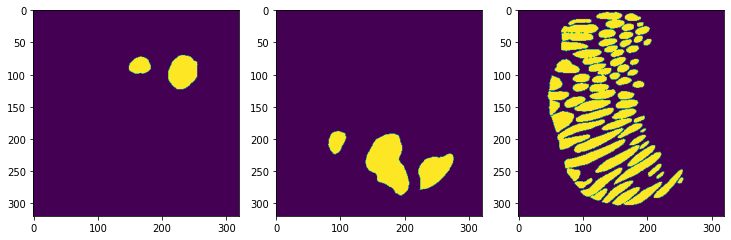

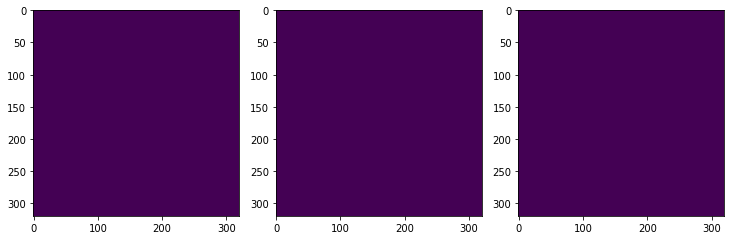

In [74]:
display_preds(display_loader, model)

## Train on different fold

In [75]:
def prepare_loaders(whole_df, val_fold, print_info=True):

    val_df = whole_df.loc[whole_df.fold == val_fold].copy()
    val_df = sample_val_to_size(val_df)
    
    if CFG.use_test_ds is not False:
        remove_indexes = list(val_df.index) + list(test_df.index)
    else:
        remove_indexes = list(val_df.index)
        
    train_df = whole_df.drop(remove_indexes[1:]).copy()

    train_df = train_df.sample(len(train_df))
    train_df.reset_index(inplace=True, drop=True)
    val_df = val_df.sample(len(val_df))
    val_df.reset_index(inplace=True, drop=True)

    if print_info:
        print('Train shape', train_df.shape)
        print('Val shape', val_df.shape)
        print(train_df.organ.value_counts())
        print(val_df.organ.value_counts())

    train_loader = prepare_train_loader(train_df, batch_size=CFG.train_bs)
    valid_loader = prepare_valid_loader(val_df, batch_size=CFG.val_bs)

    return train_loader, valid_loader

In [76]:
print('Is debugging', CFG.debugging)

Is debugging False


In [77]:
history = []
for i, new_fold in enumerate(CFG.folds_to_train_on):
    print(f'Training on fold {new_fold}')
    
    history.append({'train_loss': [], 'valid_loss': [], 'train_score': [], 'valid_score': []})
    
    model = create_model()
    model = model.to(CFG.device)

    train_loader, valid_loader = prepare_loaders(whole_train_df, new_fold, print_info=False)
    
    # Best weights should be alreay loaded, if not then perhaps they should not be and should check train flags

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=CFG.optimizer_weight_decay)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
    history_fold = run_training(
        model, optimizer, scaler, train_loader, valid_loader, display_loader,
        num_epochs=25 if CFG.debugging else 300,
        show_preds=False,
        max_no_improvement_epochs=10, # first run on fold will have decreasing VS
        print_progress=False,
        plot_progress=True,
        # scheduler=scheduler,
        no_save_for_epochs=1,
        max_run_time_mins=15 if CFG.debugging else 60
    )

    for k in history[i].keys():
        history[i][k] = history[i][k] + history_fold[k]
        
    if os.path.isfile(CFG.best_model_path):
        model.load_state_dict(torch.load(CFG.best_model_path))
    
    best_fold_path = CFG.best_fold_path.replace('.bin', f'_{new_fold}.bin')
    torch.save(model.state_dict(), best_fold_path)
    print(f'Saved model weights to {best_fold_path}')

Training on fold 1


Valid : 100%|██████████| 8/8 [00:00<00:00,  8.77it/s, acc=0.0000, gpu_memory=0.94 GB, valid_loss=0.4540]


Output()

Output()

Output()

Output()

Last epoch. Model weights saved in /kaggle/working/last_epoch.bin
------------------------------
Training time: 12.52 minutes.
------------------------------
Saved model weights to /kaggle/working/best_epoch_fold_1.bin
Training on fold 2


Valid : 100%|██████████| 8/8 [00:00<00:00,  8.84it/s, acc=0.0000, gpu_memory=0.62 GB, valid_loss=0.4600]


Output()

Output()

Output()

Output()

Last epoch. Model weights saved in /kaggle/working/last_epoch.bin
------------------------------
Training time: 33.34 minutes.
------------------------------
Saved model weights to /kaggle/working/best_epoch_fold_2.bin


# Plot history

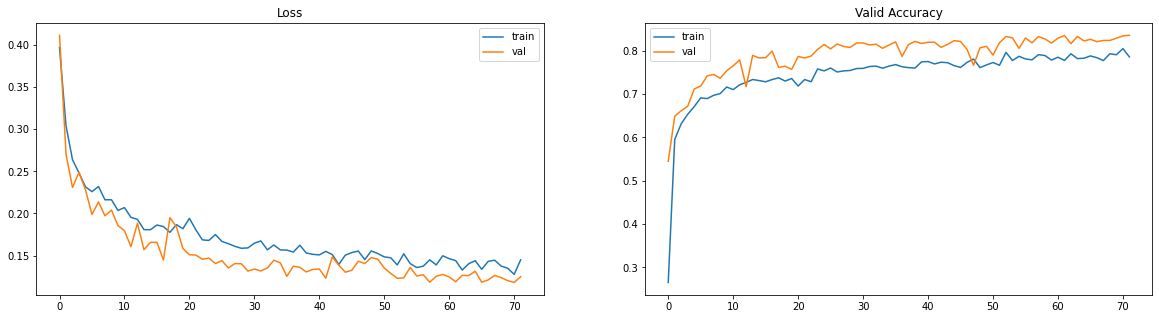

In [78]:
plot_history(history[1], save_img=True)

# Calculate Dice accuracy

In [79]:
best_fold_path = CFG.best_fold_path.replace('.bin', f'_{new_fold}.bin')
print(best_fold_path)
model.load_state_dict(torch.load(best_fold_path))

/kaggle/working/best_epoch_fold_2.bin


<All keys matched successfully>

In [80]:
# Print accuracy

test_loader = prepare_test_loader(test_df)
test_loss, test_scores = valid_one_epoch(model, test_loader, device=CFG.device, show_preds=False)
print(f"Best Test Score {test_scores:0.4f}")

val_loss, val_scores = valid_one_epoch(model, valid_loader, device=CFG.device, show_preds=False)
print(f"Best Valid Score {val_scores:0.4f}")
train_loss, train_scores = valid_one_epoch(model, train_loader, device=CFG.device, show_preds=False)
print(f"Best Train Score {train_scores:0.4f}")
display_loss, display_scores = valid_one_epoch(model, display_loader, device=CFG.device, show_preds=False)
print(f"Best Display Score {display_scores:0.4f}")


Valid : 100%|██████████| 8/8 [00:00<00:00,  8.44it/s, acc=0.9322, gpu_memory=0.60 GB, valid_loss=0.0740]


Best Test Score 0.9015


Valid : 100%|██████████| 8/8 [00:01<00:00,  7.89it/s, acc=0.8649, gpu_memory=0.56 GB, valid_loss=0.1189]


Best Valid Score 0.8351


Valid : 100%|██████████| 71/71 [00:20<00:00,  3.43it/s, acc=0.8735, gpu_memory=0.56 GB, valid_loss=0.1546]


Best Train Score 0.7881


Valid : 100%|██████████| 1/1 [00:00<00:00,  4.97it/s, acc=0.8754, gpu_memory=0.51 GB, valid_loss=0.1292]


Best Display Score 0.8754


# Visualize training resutls

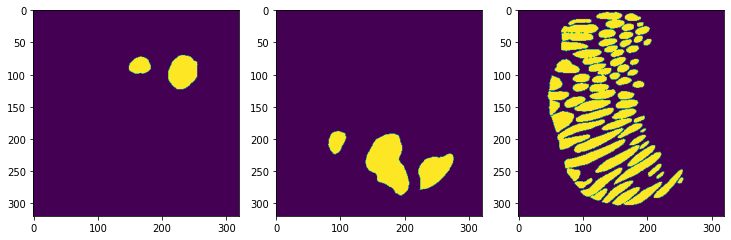

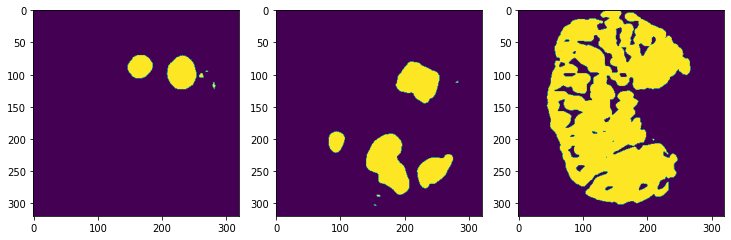

In [81]:
display_preds(display_loader, model)

# Display preds

In [82]:
def display_preds_by_side(loader, model, mask_over_img=False, img_size=4):
    for step, (imgs, msks) in enumerate(loader):
        # print(f'Step {step} {imgs.shape}')
        
        imgs = imgs.to(CFG.device)
        msks = msks.to(CFG.device)
        msks_pred = model(imgs)
        msks_pred = create_mask_from_batch_outputs(msks_pred)

        imgs = imgs.cpu().numpy()
        msks = msks.cpu().numpy()
        imgs = np.transpose(imgs, (0, 2, 3, 1)) # [4, 3, 128, 128] -> [4, 128, 128, 3]
        msks = np.transpose(msks, (0, 2, 3, 1)) # [3, 128, 128] -> [128, 128, 3]

        imgs_to_plot = []
        for img, msk, pred in zip(imgs, msks, msks_pred):
            if mask_over_img:
                imgs_to_plot.append(draw_msk_over_img(denormalize_img(img.copy()), msk))
                imgs_to_plot.append(draw_msk_over_img(denormalize_img(img.copy()), pred))
                titles = ['True', 'Pred']
            else:
                imgs_to_plot.append(denormalize_img(img))
                imgs_to_plot.append(msk)
                imgs_to_plot.append(pred)
                titles = ['Img', 'True', 'Pred']

        plot_multiple_images(imgs_to_plot, rows_num=1, cols_num=5, img_size=img_size, titles=titles)

def display_preds_amount(df, model, amount_to_display=10, mask_over_img=False, img_size=4):
    display_loader = prepare_test_loader(df[0:min(amount_to_display, len(df))], batch_size=1)
    print('Amount:', len(display_loader))

    display_preds_by_side(display_loader, model, mask_over_img, img_size)

Amount: 6


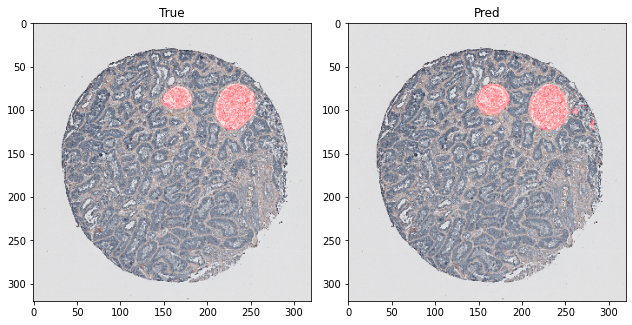

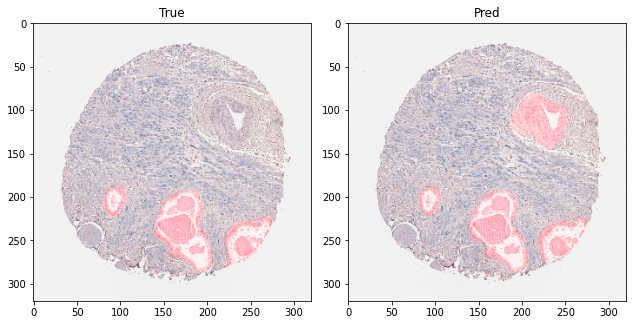

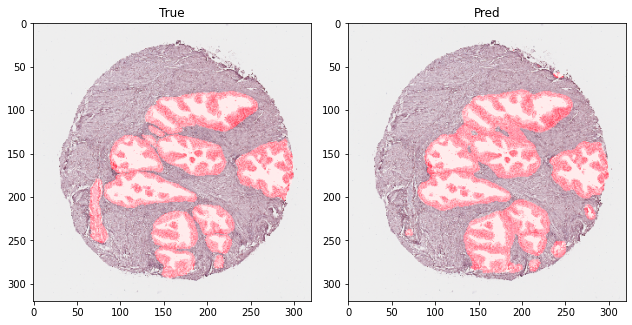

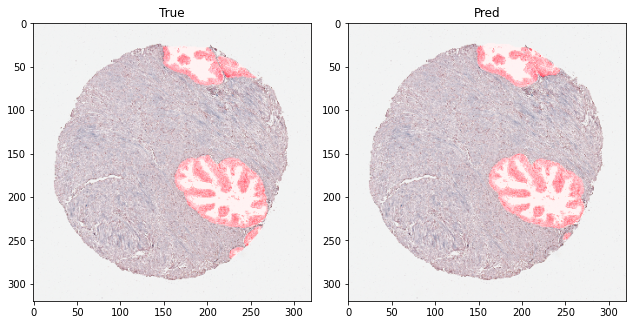

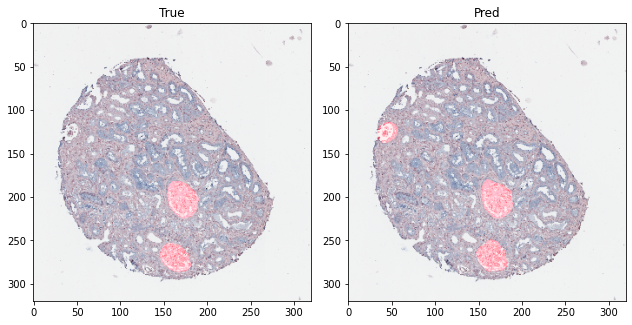

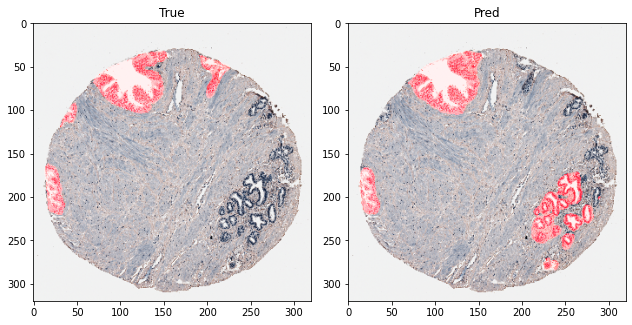

In [83]:
display_preds_amount(test_df, model, 6, mask_over_img=True, img_size=4)

Amount: 6


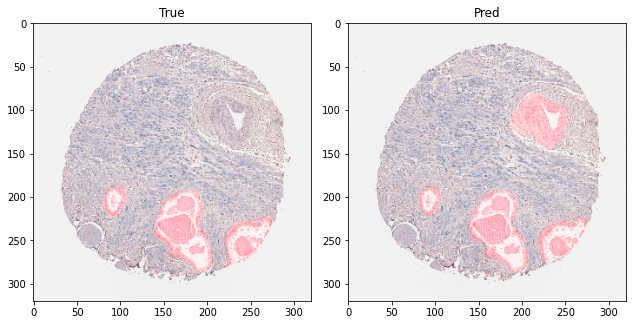

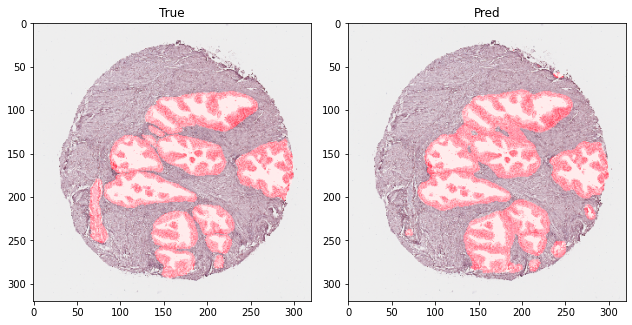

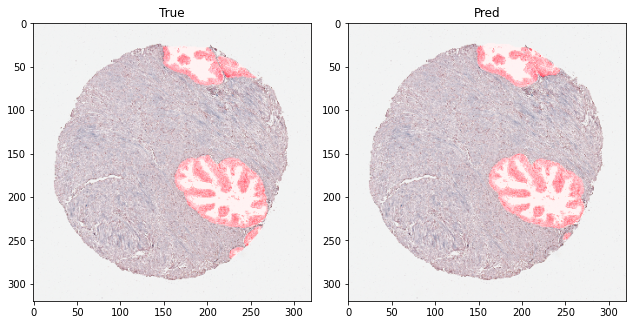

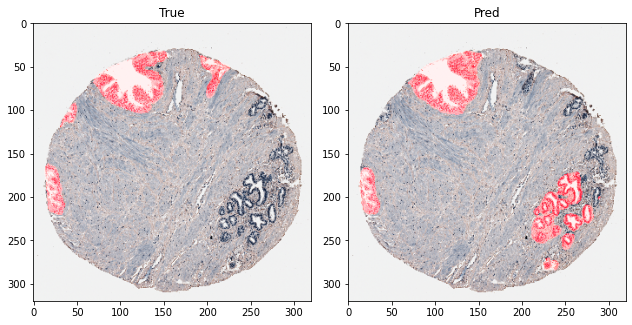

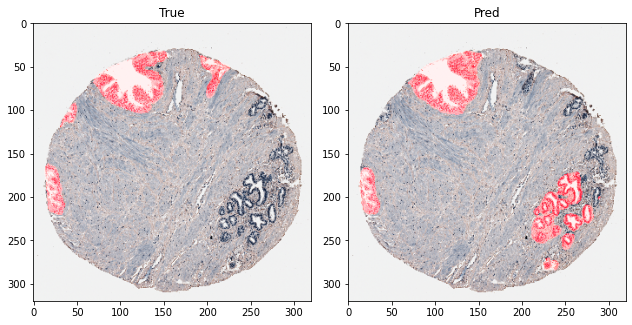

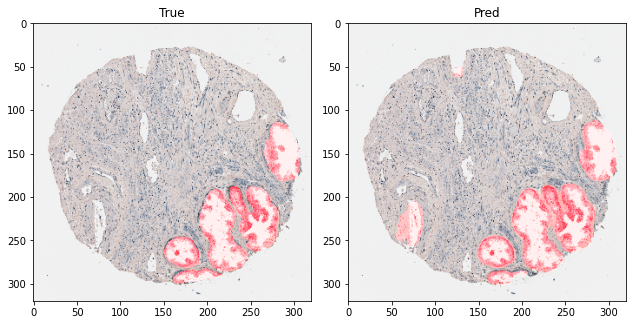

In [84]:
for_organ = 'prostate'
display_preds_amount(test_df.loc[test_df.organ==for_organ], model, 6, mask_over_img=True, img_size=4)

# Done